# **California House Price Prediction** 

## **Business Problem Understanding**

### **Features**
The data pertains to the houses found in a given California district and some summary stats based
on the 1990 census data

- longitude: The longitude coordinate of the district.
- latitude: The latitude coordinate of the district.
- housing_median_age: The median age of houses in the district.
- total_rooms: The total number of rooms in the district.
- total_bedrooms: The total number of bedrooms in the district (with some missing values).
- population: The total population in the district.
- households: The total number of households in the district.
- median_income: The median income of households in the district.
- ocean_proximity: The proximity of the district to the ocean (categorical variable).
- median_house_value: The target variable, which is the median house value in the district.

**Key dataset statistics**:

- Number of rows: 14,448
- Number of non-null values in the "total_bedrooms" column: 14,311 (some missing values)
- Data types: The majority of columns are of type float64, and "ocean_proximity" is of type object (categorical).

In [2]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

# test split
from sklearn.model_selection import train_test_split

# preprocessing
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# Cross Validation
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from sklearn.svm import SVR

In [3]:
df = pd.read_csv('data_california_house.csv')
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,median_house_value
0,-119.79,36.73,52.0,112.0,28.0,193.0,40.0,1.9750,INLAND,47500.0
1,-122.21,37.77,43.0,1017.0,328.0,836.0,277.0,2.2604,NEAR BAY,100000.0
2,-118.04,33.87,17.0,2358.0,396.0,1387.0,364.0,6.2990,<1H OCEAN,285800.0
3,-118.28,34.06,17.0,2518.0,1196.0,3051.0,1000.0,1.7199,<1H OCEAN,175000.0
4,-119.81,36.73,50.0,772.0,194.0,606.0,167.0,2.2206,INLAND,59200.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14448 entries, 0 to 14447
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           14448 non-null  float64
 1   latitude            14448 non-null  float64
 2   housing_median_age  14448 non-null  float64
 3   total_rooms         14448 non-null  float64
 4   total_bedrooms      14311 non-null  float64
 5   population          14448 non-null  float64
 6   households          14448 non-null  float64
 7   median_income       14448 non-null  float64
 8   ocean_proximity     14448 non-null  object 
 9   median_house_value  14448 non-null  float64
dtypes: float64(9), object(1)
memory usage: 1.1+ MB


### **Handling Missing Values**

In [5]:
# CHECK MISSING VALUE
df.isna().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        137
population              0
households              0
median_income           0
ocean_proximity         0
median_house_value      0
dtype: int64

In [6]:
# CHECK DUPLICATE DATAS
df.duplicated().sum()

0

### **EDA**

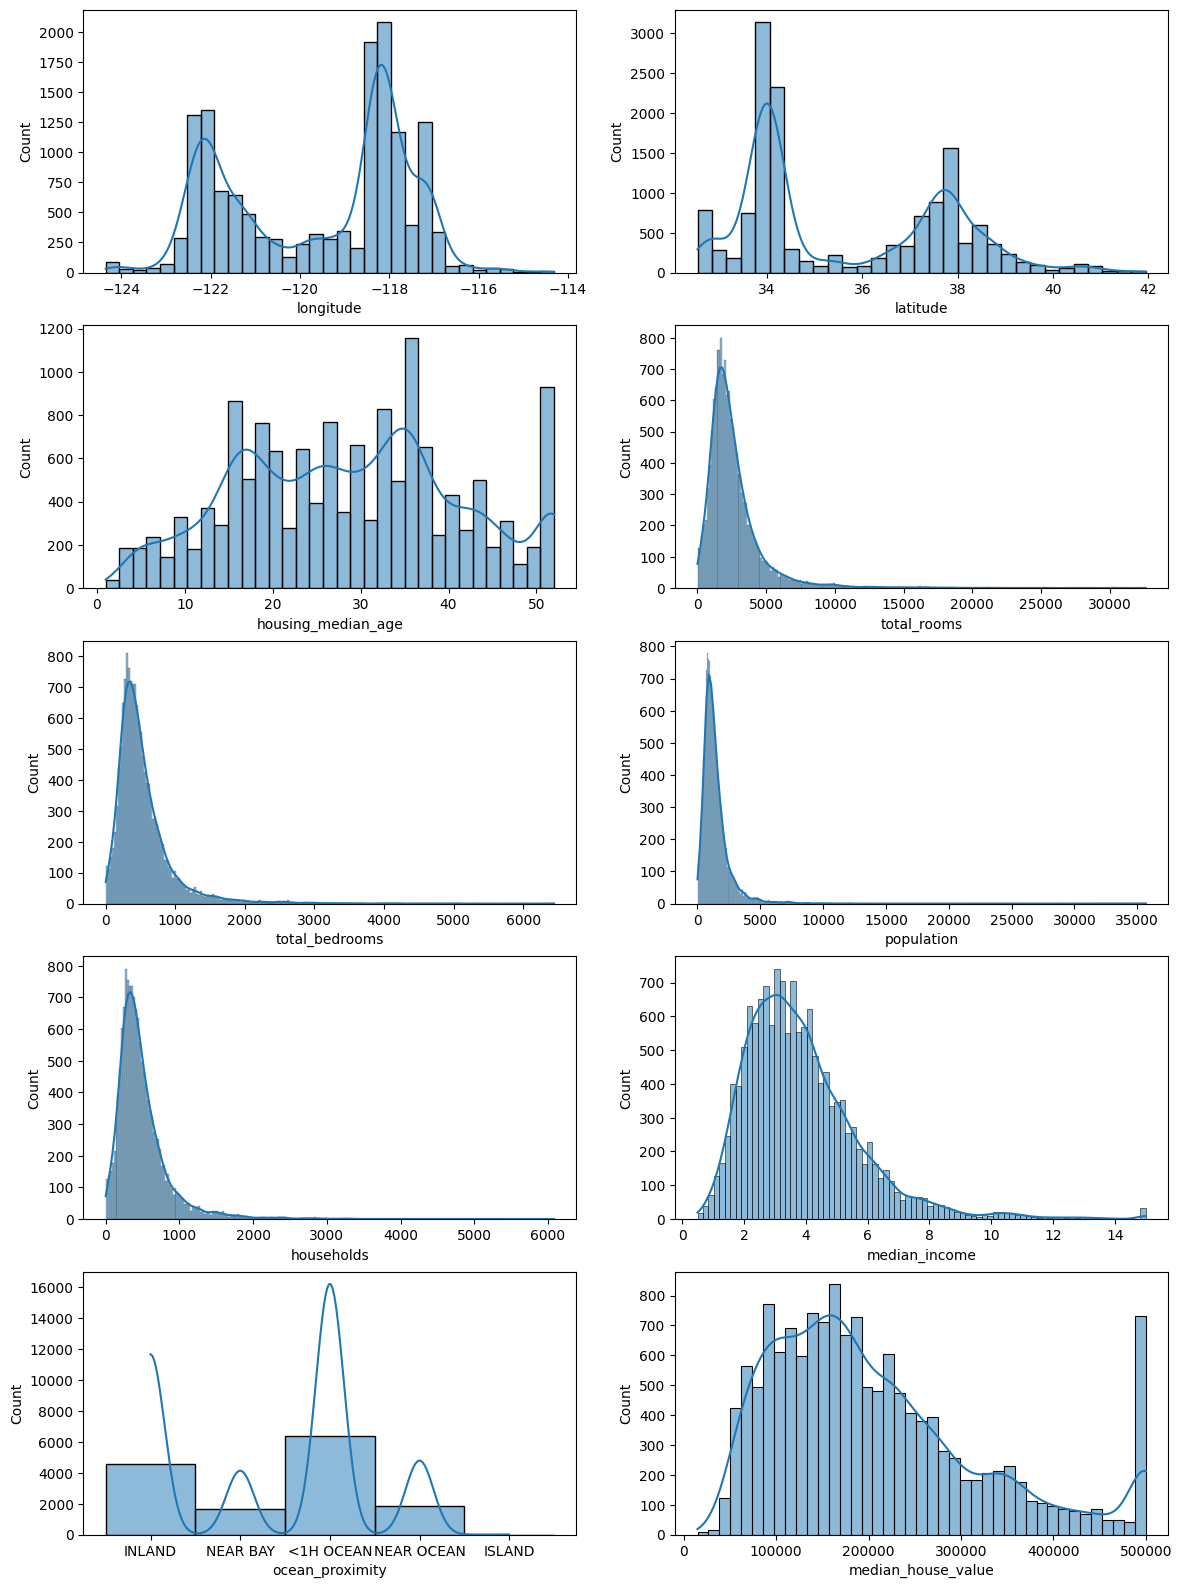

In [7]:
plt.figure(figsize=(14,28))
pltnum = 1
for column in df.describe(exclude=int).columns:
    plt.subplot(7,2,pltnum)
    sns.histplot(data=df, x=column, kde=True)
    pltnum += 1

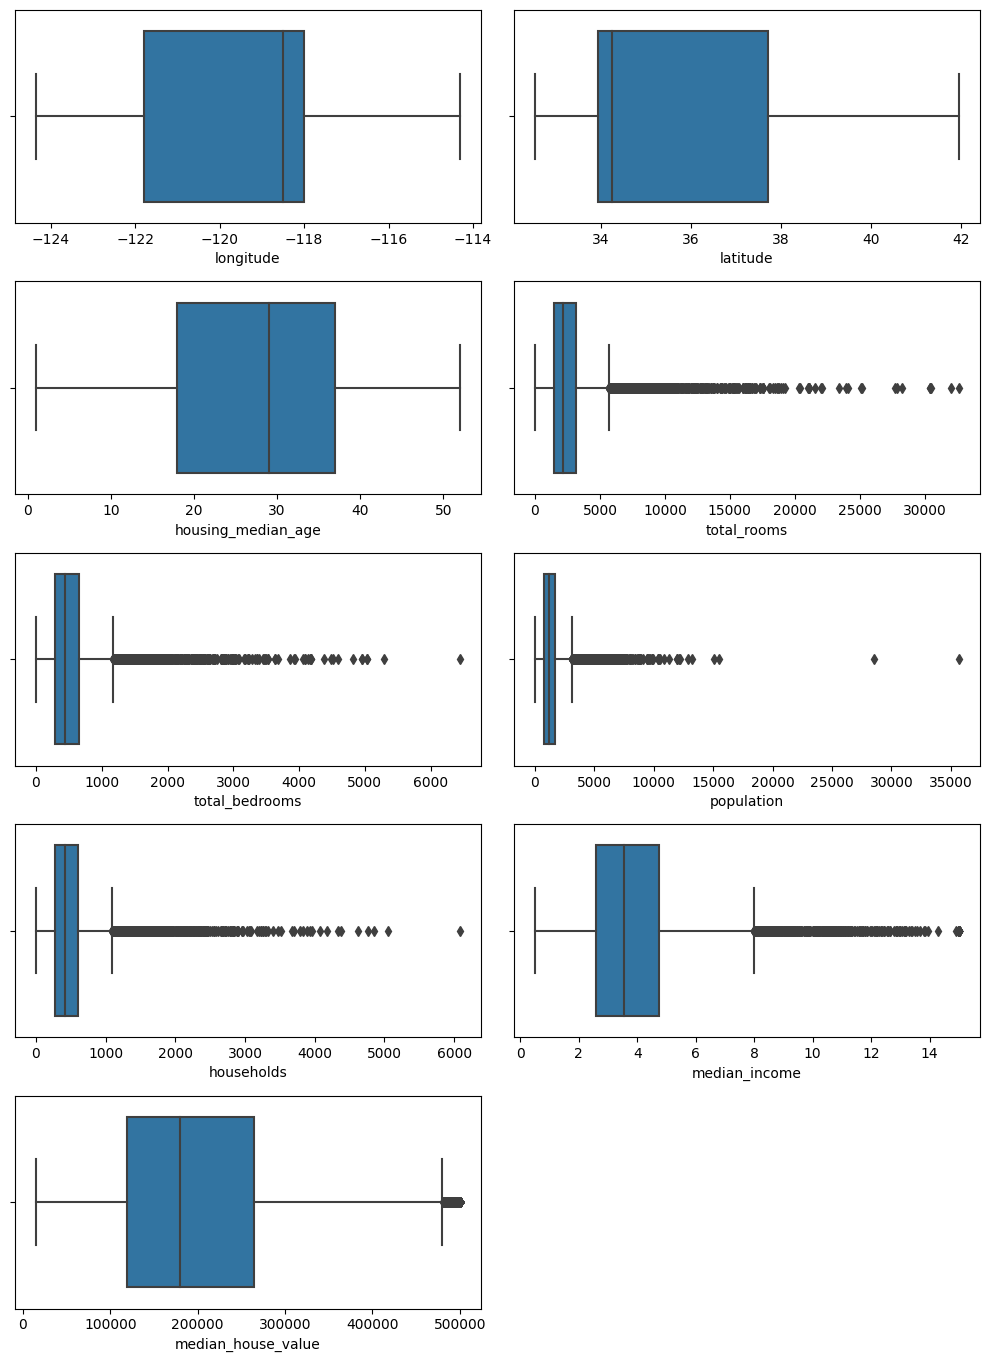

In [8]:
plt.figure(figsize=(10,16))
pltnum = 1
# filter columns that are numeric 
num_cols = df.select_dtypes(include=['int', 'float']).columns

for column in num_cols:
    plt.subplot(6,2,pltnum)
    sns.boxplot(data=df, x=column)
    pltnum += 1
    
plt.tight_layout()
plt.show()

### **Handling Outliers**

In [9]:
def check_outliers(df, column_name):
    # Calculate quartiles (Q1 and Q3)
    q1 = np.percentile(df[column_name].values, 25)
    q3 = np.percentile(df[column_name].values, 75)

    # Calculate the IQR range
    iqr = q3 - q1

    # Calculate lower and upper bounds
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr

    # Identify values outside the upper and lower bounds
    outliers = (df[column_name].values < lower) | (df[column_name].values > upper)

    # Count the number of outliers
    num_outliers = np.sum(outliers)

    # Print the lower and upper bounds
    print(f"==== {column_name} ====")
    print("Lower Bound:", lower)
    print("Upper Bound:", upper)
    print(f"Number of Outliers: {num_outliers} \n")


In [10]:
columns_to_check = ['total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value']

for cols in columns_to_check:
    check_outliers(df, cols)

==== total_rooms ====
Lower Bound: -1094.5
Upper Bound: 5693.5
Number of Outliers: 900 

==== total_bedrooms ====
Lower Bound: nan
Upper Bound: nan
Number of Outliers: 0 

==== population ====
Lower Bound: -626.0
Upper Bound: 3134.0
Number of Outliers: 827 

==== households ====
Lower Bound: -208.5
Upper Bound: 1091.5
Number of Outliers: 842 

==== median_income ====
Lower Bound: -0.6776500000000012
Upper Bound: 7.984350000000001
Number of Outliers: 482 

==== median_house_value ====
Lower Bound: -96850.0
Upper Bound: 480350.0
Number of Outliers: 757 



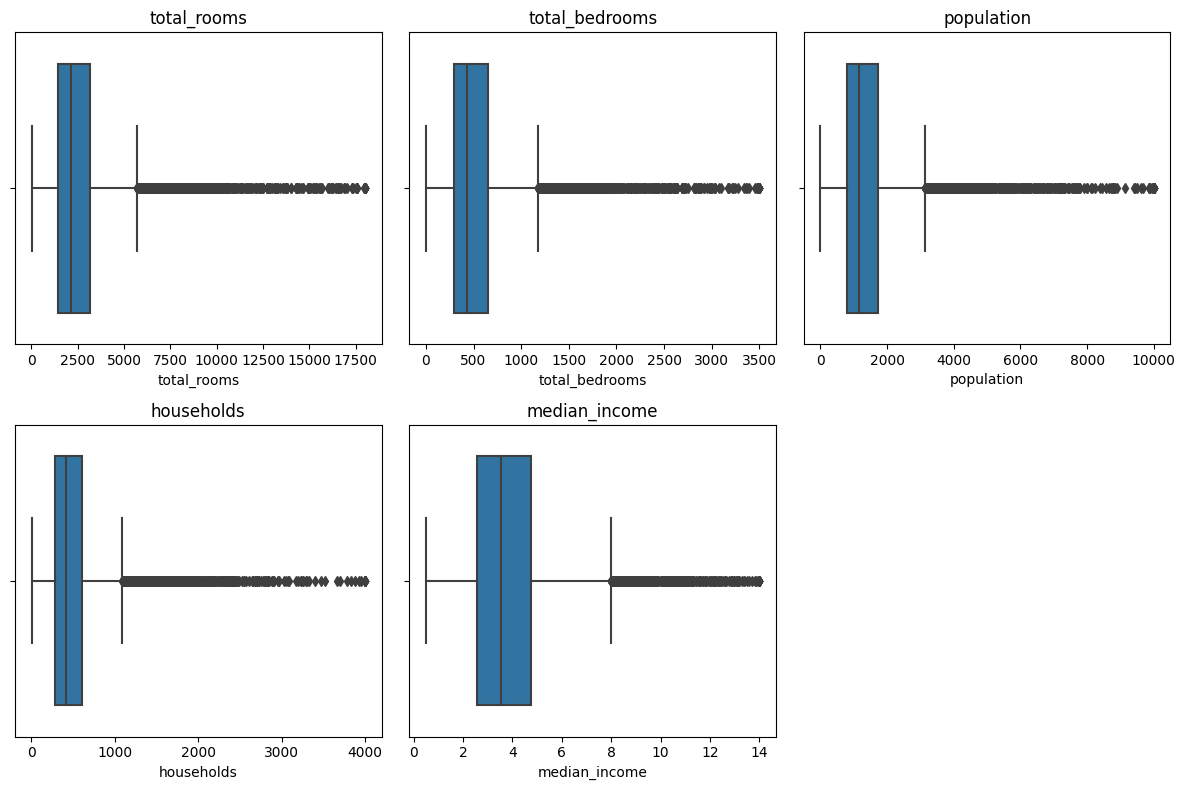

In [11]:
thresholds = {
    'total_rooms': 18000,
    'total_bedrooms': 3500,
    'population': 10000,
    'households': 4000,
    'median_income': 14
}

# Apply thresholds to the respective columns
for col, threshold in thresholds.items():
    df[col] = np.where(df[col] > threshold, threshold, df[col])

# Create boxplots for each column
plt.figure(figsize=(12, 8))
for i, col in enumerate(thresholds.keys(), 1):
    plt.subplot(2, 3, i)
    sns.boxplot(data=df, x=col)
    plt.title(col)
    
plt.tight_layout()
plt.show()

### **Data Splitting**

In [12]:
# Define X and y value
X = df.drop(columns=['median_house_value'])
y = df['median_house_value']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2)

In [13]:
df.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'ocean_proximity', 'median_house_value'],
      dtype='object')

### **Preprocessing**

In [14]:
# Create pipelines for scaling
std_pipe = Pipeline([
    ('std_scaler', StandardScaler())
])

rbst_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('rbst_scaler', RobustScaler())
])

# Select numerical columns excluding 'longitude', 'latitude', and 'housing_median_age'
rbst_num_attribs = df.select_dtypes(include=['number']).columns.difference(['longitude', 'latitude', 'housing_median_age', 'median_house_value'])
std_attribs = ['longitude', 'latitude', 'housing_median_age']
cat_attribs = ['ocean_proximity']

# Define the ColumnTransformer
transformer = ColumnTransformer([
    ('num_rbst_pipe', rbst_pipe, rbst_num_attribs),
    ('num_std_pipe', std_pipe, std_attribs),
    ('onehot', OneHotEncoder(), cat_attribs)
], remainder='passthrough')

transformer

ColumnTransformer(remainder='passthrough',
                  transformers=[('num_rbst_pipe',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('rbst_scaler',
                                                  RobustScaler())]),
                                 Index(['households', 'median_income', 'population', 'total_bedrooms',
       'total_rooms'],
      dtype='object')),
                                ('num_std_pipe',
                                 Pipeline(steps=[('std_scaler',
                                                  StandardScaler())]),
                                 ['longitude', 'latitude',
                                  'housing_median_age']),
                                ('onehot', OneHotEncoder(),
                                 ['ocean_proximity'])])

In [15]:
# Fit the ColumnTransformer to your training data
transformer.fit(X_train)

# Transform your training data
X_train_transformed = transformer.transform(X_train)

# Transform your test data using the same transformer
X_test_transformed = transformer.transform(X_test)

### **Cross Validation**

In [16]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# Define the algorithms
tree = DecisionTreeRegressor(max_depth=5, random_state=0)
rf = RandomForestRegressor(random_state=0)
xgb = XGBRegressor(random_state=0)
linreg = LinearRegression()
ridge = Ridge(alpha=1)
lasso = Lasso(alpha=1)
svr = SVR()

# Cross-validation
list_algo = [tree, rf, xgb, svr, linreg, ridge, lasso]

# Create lists to store metrics
metrics = ['RMSE', 'MAE', 'MAPE']
scores = {metric: [] for metric in metrics}
means = {metric: [] for metric in metrics}
stds = {metric: [] for metric in metrics}

for algo in list_algo:
    crossval = KFold(n_splits=5, shuffle=True, random_state=1)
    
    # Create the pipeline
    pipe_model = Pipeline([
        ('preprocessing', transformer),  # Assuming you've defined 'transformer' elsewhere
        ('modeling', algo)
    ])
    
    for metric in metrics:
        if metric == 'RMSE':
            scoring = 'neg_root_mean_squared_error'
        elif metric == 'MAE':
            scoring = 'neg_mean_absolute_error'
        elif metric == 'MAPE':
            scoring = 'neg_mean_absolute_percentage_error'

        model_cv = cross_val_score(
            estimator=pipe_model,
            X=X_train,
            y=y_train,
            cv=crossval,
            scoring=scoring,
            error_score='raise'
        )

        scores[metric].append(model_cv)
        means[metric].append(model_cv.mean())
        stds[metric].append(model_cv.std())

# Create a DataFrame to store the results
df_model_metrics = pd.DataFrame({
    'Algorithm': [str(algo) for algo in list_algo],
    'RMSE Scores': scores['RMSE'],
    'RMSE Mean': means['RMSE'],
    'RMSE Std': stds['RMSE'],
    'MAE Scores': scores['MAE'],
    'MAE Mean': means['MAE'],
    'MAE Std': stds['MAE'],
    'MAPE Scores': scores['MAPE'],
    'MAPE Mean': means['MAPE'],
    'MAPE Std': stds['MAPE']
})

df_model_metrics

c:\Users\valou\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.143e+11, tolerance: 1.245e+10
  model = cd_fast.enet_coordinate_descent(
c:\Users\valou\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.533e+12, tolerance: 1.249e+10
  model = cd_fast.enet_coordinate_descent(
c:\Users\valou\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the sca

,Algorithm,RMSE Scores,RMSE Mean,RMSE Std,MAE Scores,MAE Mean,MAE Std,MAPE Scores,MAPE Mean,MAPE Std
0,"DecisionTreeRegressor(max_depth=5, random_stat...","[-71959.75791016586, -72826.55175114899, -6866...",-71169.038683,1484.148277,"[-50833.01001093419, -51708.93905742643, -4915...",-50528.307363,842.097190,"[-0.29086745827241833, -0.2964388758443862, -0...",-0.285438,0.008429
1,RandomForestRegressor(random_state=0),"[-51037.40331584791, -53625.48465681372, -4891...",-50543.213616,1713.150046,"[-33548.81331747405, -34688.750038927334, -329...",-33425.376030,671.195636,"[-0.19716284083252972, -0.19232254461754358, -...",-0.186959,0.006969
2,"XGBRegressor(base_score=None, booster=None, ca...","[-49401.3925191579, -52347.96371896118, -47772...",-49494.338695,1590.783104,"[-32813.79556390571, -33738.66838522518, -3206...",-32897.570903,533.396925,"[-0.18983163997794608, -0.18643972806215778, -...",-0.182950,0.005938
3,SVR(),"[-116134.89761536241, -115769.84488159066, -12...",-118546.676360,2176.396570,"[-87117.96714291701, -86538.95857423838, -9015...",-88445.111996,1401.010194,"[-0.5379587105547536, -0.5239578583195731, -0....",-0.526279,0.007419
4,LinearRegression(),"[-68395.22113584638, -68246.28216826524, -6726...",-67951.004038,1223.246743,"[-50232.70962658549, -49865.21564833245, -4938...",-49911.672119,604.051985,"[-0.2979072677631661, -0.2948288362364107, -0....",-0.288844,0.006716
5,Ridge(alpha=1),"[-68422.14432388701, -68227.14106812056, -6726...",-67952.459488,1225.051900,"[-50250.68761572722, -49832.807808693135, -493...",-49909.209233,607.137456,"[-0.29792937753231263, -0.2947290418423295, -0...",-0.288831,0.006704
6,Lasso(alpha=1),"[-68399.78223045044, -68242.06494019071, -6726...",-67951.022064,1223.554068,"[-50236.41704138122, -49861.574479806084, -493...",-49911.757367,604.633194,"[-0.2979128841447906, -0.2948191895770172, -0....",-0.288844,0.006716


### **Predict to Test Set with the Benchmark Model**

In [39]:
# Benchmark 2 model terbaik
models = {
    'XGB': XGBRegressor(random_state=1),
    'RandomForest': RandomForestRegressor(random_state=1)
}

score_rmse = []
score_mae = []
score_mape = []

# Prediksi pada test set
for i in models:

    model = Pipeline([
        ('preprocessing', transformer),
        ('model', models[i])
        ])

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    score_rmse.append(np.sqrt(mean_squared_error(y_test, y_pred)))
    score_mae.append(mean_absolute_error(y_test, y_pred))
    score_mape.append(mean_absolute_percentage_error(y_test, y_pred))

score_before_tuning = pd.DataFrame({'RMSE': score_rmse, 'MAE': score_mae, 'MAPE': score_mape}, index=models.keys())
score_before_tuning

,RMSE,MAE,MAPE
XGB,48695.959662,32826.426288,0.185892
RandomForest,50434.847768,33319.561834,0.187996


### **Hyperparameter Tuning**

In [40]:
# Kedalaman pohon
max_depth = list(np.arange(1, 11))

# Learning rate
learning_rate = list(np.arange(1, 100)/100)

# Jumlah pohon
n_estimators = list(np.arange(100, 201))

# Jumlah baris tiap pohon (% dari total baris train set)
subsample = list(np.arange(2, 10)/10)

# Hyperparam space XGboost
hyperparam_space_xgb = {
    'model__max_depth': max_depth, 
    'model__learning_rate': learning_rate,
    'model__n_estimators': n_estimators,
    'model__subsample': subsample,
}

In [44]:
# Benchmark model dengan hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV


xgb = XGBRegressor(random_state=1, verbosity=0)

# Membuat algorithm chains
estimator_xgb = Pipeline([
        ('preprocessing', transformer),
        ('model', xgb)
        ])

crossval = KFold(n_splits=5, shuffle=True, random_state=1)

# Hyperparameter tuning
random_xgb = RandomizedSearchCV(
    estimator_xgb, 
    param_distributions = hyperparam_space_xgb,
    n_iter = 200,
    cv = crossval, 
    scoring = ['neg_root_mean_squared_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error'], 
    n_jobs = -1,
    refit = 'neg_root_mean_squared_error', # Hanya bisa memilih salah stau metric untuk optimisasi
    random_state = 1  
)

In [45]:
# Fitting data training untuk mencari parameter terbaik
random_xgb.fit(X_train, y_train)

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=1, shuffle=True),
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('num_rbst_pipe',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('rbst_scaler',
                                                                                                RobustScaler())]),
                                                                               Index(['households', 'median_income', 'population', 'total_bedrooms',
       'total...
                                        'model__n_estimators': [100, 101, 102,
                                                                103, 104, 105,
                                                                106, 107, 108,
                                                                109, 110, 111,
                                                                112, 113, 114,
                                                                115, 116, 117,
                                                                118, 119, 120,
                                                                121, 122, 123,
                                                                124, 125, 126,
                                                                127, 128, 129, ...],
                                        'model__subsample': [0.2, 0.3, 0.4, 0.5,
                                                             0.6, 0.7, 0.8,
                                                             0.9]},
                   random_state=1, refit='neg_root_mean_squared_error',
                   scoring=['neg_root_mean_squared_error',
                            'neg_mean_absolute_error',
                            'neg_mean_absolute_percentage_error'])

In [46]:
# Melihat hasil tuning dalam bentuk dataframe. Diurutkan berdasarkan RMSE, MAE & MAPE
pd.DataFrame(random_xgb.cv_results_).sort_values(by=['rank_test_neg_root_mean_squared_error', 'rank_test_neg_mean_absolute_error', 'rank_test_neg_mean_absolute_percentage_error']).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__subsample,param_model__n_estimators,param_model__max_depth,param_model__learning_rate,params,split0_test_neg_root_mean_squared_error,...,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error,split0_test_neg_mean_absolute_percentage_error,split1_test_neg_mean_absolute_percentage_error,split2_test_neg_mean_absolute_percentage_error,split3_test_neg_mean_absolute_percentage_error,split4_test_neg_mean_absolute_percentage_error,mean_test_neg_mean_absolute_percentage_error,std_test_neg_mean_absolute_percentage_error,rank_test_neg_mean_absolute_percentage_error
112,2.298481,0.180369,0.098076,0.016876,0.6,198,7,0.1,"{'model__subsample': 0.6, 'model__n_estimators...",-48639.474831,...,778.992509,4,-0.188222,-0.184667,-0.170311,-0.164292,-0.179083,-0.177315,0.008886,6
185,2.677959,0.116675,0.103222,0.008428,0.9,154,8,0.07,"{'model__subsample': 0.9, 'model__n_estimators...",-48376.610420,...,739.687422,1,-0.184394,-0.181592,-0.166324,-0.164884,-0.179245,-0.175288,0.008086,2
7,1.245504,0.078321,0.071479,0.010133,0.9,152,6,0.15,"{'model__subsample': 0.9, 'model__n_estimators...",-47583.169920,...,665.828940,3,-0.183680,-0.184109,-0.168851,-0.167317,-0.180187,-0.176829,0.007285,4
108,4.168793,0.109825,0.137814,0.013809,0.7,181,9,0.09,"{'model__subsample': 0.7, 'model__n_estimators...",-49025.751062,...,852.205079,2,-0.185391,-0.183280,-0.166154,-0.163208,-0.177186,-0.175044,0.008928,1
116,2.546811,0.159178,0.086172,0.003889,0.6,151,8,0.1,"{'model__subsample': 0.6, 'model__n_estimators...",-49087.480239,...,715.308350,6,-0.189918,-0.183499,-0.167895,-0.165805,-0.178572,-0.177138,0.009162,5


In [47]:
# Cek skor dan params terbaik
print('XGBoost')
print('Best_score:', random_xgb.best_score_)
print('Best_params:', random_xgb.best_params_)

XGBoost
Best_score: -48246.42365699207
Best_params: {'model__subsample': 0.6, 'model__n_estimators': 198, 'model__max_depth': 7, 'model__learning_rate': 0.1}


In [29]:
# Model XGBoost
model = {'XGB': XGBRegressor(random_state=1)}

# Define model terhadap estimator terbaik
xgb_tuning = random_xgb.best_estimator_

# Fitting model
xgb_tuning.fit(X_train, y_train)

# Predict test set
y_pred_xgb_tuning = xgb_tuning.predict(X_test)

# Simpan nilai metrics RMSE, MAE & MAPE setelah tuning
rmse_xgb_tuning = np.sqrt(mean_squared_error(y_test, y_pred_xgb_tuning))
mae_xgb_tuning = mean_absolute_error(y_test, y_pred_xgb_tuning)
mape_xgb_tuning = mean_absolute_percentage_error(y_test, y_pred_xgb_tuning)

score_after_tuning = pd.DataFrame({'RMSE': rmse_xgb_tuning, 'MAE': mae_xgb_tuning, 'MAPE': mape_xgb_tuning}, index=model.keys())
score_after_tuning

,RMSE,MAE,MAPE
XGB,48199.89218,31942.48118,0.179252


### **Before Tuning Results**

In [30]:
# Sebelum hyperparameter tuning
pd.DataFrame(score_before_tuning.loc['XGB']).T

,RMSE,MAE,MAPE
XGB,48695.959662,32826.426288,0.185892


### **Actual vs. Predicted (Before Tuning)**

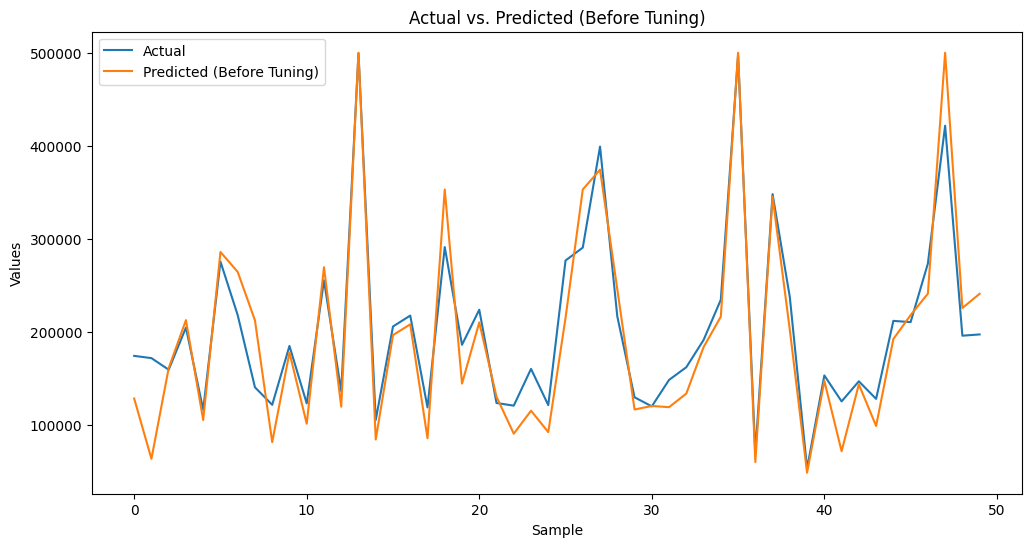

In [55]:
import matplotlib.pyplot as plt

# Create a DataFrame with 'Predicted' and 'Actual' columns
test_before_tuning = pd.DataFrame({'Predicted (Before Tuning)': y_pred, 'Actual': y_test})

# Reset the index and drop the 'index' column
test_before_tuning = test_before_tuning.reset_index()
test_before_tuning = test_before_tuning.drop(['index'], axis=1)

# Create a line plot for the first 50 data points
plt.figure(figsize=(12, 6))
plt.plot(test_before_tuning[:50])
plt.title('Actual vs. Predicted (Before Tuning)')
plt.xlabel('Sample')
plt.ylabel('Values')
plt.legend(['Actual', 'Predicted (Before Tuning)'])
plt.show()


### **After Tuning Results**

In [31]:
# Setelah hyperparameter tuning
score_after_tuning

,RMSE,MAE,MAPE
XGB,48199.89218,31942.48118,0.179252


### **Actual vs. Predicted (After Tuning)**

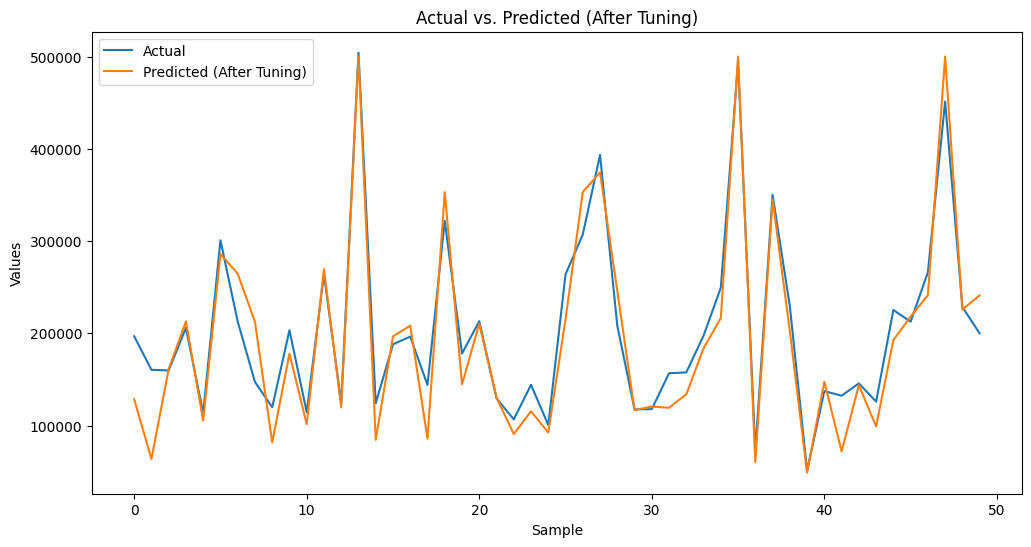

In [56]:
import matplotlib.pyplot as plt

# Create a DataFrame with 'Predicted' and 'Actual' columns
test_after_tuning = pd.DataFrame({'Predicted (After Tuning)': y_pred_xgb_tuning, 'Actual': y_test})

# Reset the index and drop the 'index' column
test_after_tuning = test_after_tuning.reset_index()
test_after_tuning = test_after_tuning.drop(['index'], axis=1)

# Create a line plot for the first 50 data points
plt.figure(figsize=(12, 6))
plt.plot(test_after_tuning[:50])
plt.title('Actual vs. Predicted (After Tuning)')
plt.xlabel('Sample')
plt.ylabel('Values')
plt.legend(['Actual', 'Predicted (After Tuning)'])
plt.show()
